## AB Tests

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

# 1. Оценка результатов AB теста

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [146]:
df_student_1 = pd.read_csv('data/data/dataset_part1_students.csv', sep = '\t')

In [147]:
df_student_1

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.067689,1.0,0.679204,0.648429,0.230049,0.097030,0.336183,0.462242,0.018863,0.735293,0.460324,0.920792
19996,6.044203,1.0,0.424129,0.138698,0.729584,0.618014,0.607084,0.976012,0.248405,0.691192,0.696342,0.585681
19997,2.569386,0.0,0.058754,0.932489,0.537246,0.878644,0.615907,0.960572,0.161242,0.440243,0.349912,0.806085
19998,0.964184,1.0,0.639663,0.291877,0.111292,0.066558,0.674742,0.043582,0.500528,0.331296,0.782937,0.005246


In [4]:
df_student_1.W.value_counts()

1.0    10446
0.0     9554
Name: W, dtype: int64

In [5]:
df_treat_1 = df_student_1.loc[df_student_1.W == 1.0] # целевая группа(есть изменения)

In [6]:
df_control_1 = df_student_1.loc[df_student_1.W != 1.0] # контрольная группа

### Проверяем предположение о рандомизированности эксперимента.

Для этого посмтроим классификатор, используя в качестве таргета принадлежность к целевой или контрольной группе. 

In [7]:
logreg = LogisticRegression()
cross_val_score(logreg, df_student_1.drop(columns = ['W', 'y']), df_student_1.W).mean()

0.7495

Логистическая регрессия хорошо классифицирует данные, следовательно данные распределены не рандомно (качество рандомизации плохое)

Так как у нас нерандомизированный эксперимент сделаем предположение, что выполняются условия:

    Unconfoundedness - Treatment assignment не зависит от результата эксперимента при условии контроля за X.
    Overlap - Нет таких характеристик объектов, для которых не возможен treatment.

### 1. Гипотеза о равенстве средних в выборках

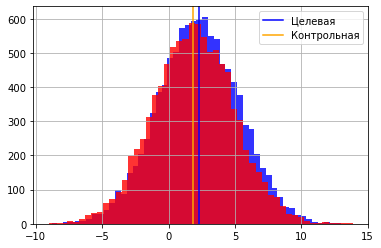

In [8]:
plt.figure()
# plt.hist(df_treat_1.y,alpha=0.8, bins = 50);
# plt.hist(df_control_1.y,alpha=0.8, bins = 50);

df_treat_1.y.hist(alpha=0.8, bins = 50, color = 'blue')
df_control_1.y.hist(alpha=0.8, bins = 50,color = 'red')
plt.axvline(df_treat_1.y.mean(), color = 'blue')
plt.axvline(df_control_1.y.mean(), color = 'orange')

# sns.distplot(df_treat_1.y)
# sns.distplot(df_control_1.y)
plt.legend(['Целевая', 'Контрольная'])
plt.show()

Распределение похоже на нормальное

Так же применим тест Нормалтест(Хи2).

Он проверяет имеет ли выборка данных нормальное распределение.

In [9]:
stat, p = stats.normaltest(df_treat_1.y)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  1.340089439214199 
P-value =  0.511685694891655


In [10]:
stat, p = stats.normaltest(df_control_1.y)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  0.06178545963522806 
P-value =  0.9695795744755934


P-value больше 5%, следовательно нулевую гипотезу мы отклонить не можем, и распределение данных является близким к нормальному.

Так как выборки у нас несвязанные, то применим т-тест для несвязанных выборок.

In [11]:
stat, p = stats.ttest_ind(df_treat_1.y, df_control_1.y, equal_var  = False)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  9.332608430209014 
P-value =  1.1387356403808485e-20


P-value меньше 5%, следовательно отклоним нулевую гипотезу. Сделаем вывод о том что среднее значение у данных выборок отличается.

### 2. Treatment effect нашего воздействия

Разность средних значений

In [12]:
np.mean(df_treat_1.y) - np.mean(df_control_1.y)

0.4001031055444413

### 3. Методы оценки ATE с учетом особенностей данных.

С учетом того, что мы не знаем значение Y[0] до эксперимента, то большинство методов для оценки ATE нам не подходят, возьмем те, где не используются знания о предыдущем значении Y.

Использование регрессии в оценке эффекта

In [13]:
linreg = LinearRegression()

In [483]:
# linreg.fit(df_treat_1.drop(columns = ['W', 'y']), df_treat_1.y)
linreg.fit(df_student_1.drop(columns = ['y']), df_student_1.y)

LinearRegression()

In [484]:
# Treatment effect
print('ATE = ', linreg.coef_[0])

ATE =  0.5133854882565404


### 4. Проанализируйте, сравните результаты применения различных методов.

Мы использовали два метода для оценки Treatment effect - регрессия и разность средних, так как в этих методах не испотльзуются значение целевой переменной в нулевой момент времени.

### 5. В явном виде выпишите выводы.

В итоге:

    1) Тритмент и контрол группы распределены неравномерно(10446,9554). Так же эксперимент нерандомезированный, так как 
    классификатор может выделить тритмент и контрол группу с достаточной точностью. Следовательно сделаем предположения, что 
    выполняются условия Unconfoundedness, Overlap.
    Так же мы построили распределение целевой переменной в зависимости от принадлежнасти к целевой группе, оно близко к 
    нормальному.
    При проведении T-testa получили значение P-value меньше 5%, следовательно среднее значения в выборках отличается.
    2) Нашли Treatment effect нашего воздействия:
        а) Для разности средних - 0.4
        б) Для регрессии - 0.51 
    Разность оценки эффекта данных методов связана с тем, что в разности средних мы не учитываем вектор X[], а считаем 
    разницу средних значений по выборкам.
    Регрессионную модель мы строим на всех фичах X, и уже в зависимости от них ищем Treatment effect. Следовательно 
    регрессионный метод более объективный.
    3) По результатам А/Б теста можно сделать вывод о том, что при данном воздействии целевая переменная увеличится в 
    среднем на 0.51.
    

# 2. Оценка результатов AB теста с показателями до начала эксперимента

In [16]:
df_student_2 = pd.read_csv('data/data/dataset_part2_students.csv', sep = '\t')

In [17]:
df_student_2

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.323575,1.207956,1.0,0.280489,0.812310,0.515489,0.959787,0.771603,0.131391,0.401038,0.825225,0.631631,0.824960
9996,4.133119,1.636214,1.0,0.352855,0.737570,0.610029,0.861363,0.076608,0.650758,0.639069,0.339857,0.762911,0.406340
9997,3.124242,-1.984834,0.0,0.079105,0.771808,0.409021,0.982742,0.599735,0.243066,0.562383,0.727493,0.043481,0.895637
9998,1.366205,0.777716,1.0,0.319164,0.715711,0.293048,0.493352,0.628071,0.857757,0.235775,0.417768,0.728639,0.197892


In [18]:
df_student_2.W.value_counts()

1.0    5240
0.0    4760
Name: W, dtype: int64

### 1. Проверить все требуемые гипотезы

In [19]:
logreg = LogisticRegression()
cross_val_score(logreg, df_student_2.drop(columns = ['W', 'y_1', 'y_0']), df_student_2.W).mean()

0.7431000000000001

Логистическая регрессия хорошо классифицирует данные, следовательно данные распределены не рандомно (качество рандомизации плохое)

Так как у нас нерандомизированный эксперимент сделаем предположение, что выполняются условия:

    Unconfoundedness - Treatment assignment не зависит от результата эксперимента при условии контроля за X.
    Overlap - Нет таких характеристик объектов, для которых не возможен treatment.

Проверим распределения на нормальность

In [20]:
df_treat_2 = df_student_2.loc[df_student_2.W == 1]
df_control_2 = df_student_2.loc[df_student_2.W == 0]

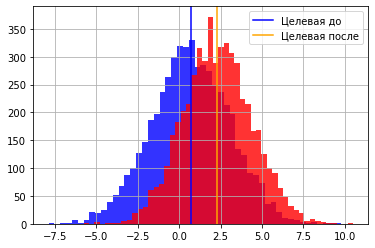

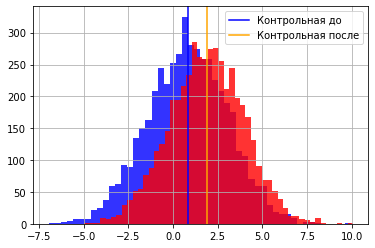

In [21]:
plt.figure()

df_treat_2.y_0.hist(alpha=0.8, bins = 50, color = 'blue')
df_treat_2.y_1.hist(alpha=0.8, bins = 50,color = 'red')
plt.axvline(df_student_2.loc[df_student_2.W == 1].y_0.mean(), color = 'blue')
plt.axvline(df_student_2.loc[df_student_2.W == 1].y_1.mean(), color = 'orange')

plt.legend(['Целевая до', 'Целевая после'])
plt.show()
plt.figure()

df_control_2.y_0.hist(alpha=0.8, bins = 50, color = 'blue')
df_control_2.y_1.hist(alpha=0.8, bins = 50,color = 'red')
plt.axvline(df_student_2.loc[df_student_2.W == 0].y_0.mean(), color = 'blue')
plt.axvline(df_student_2.loc[df_student_2.W == 0].y_1.mean(), color = 'orange')

plt.legend(['Контрольная до', 'Контрольная после'])
plt.show()

Проверим распределения на нормальность

In [22]:
stat, p = stats.normaltest(df_treat_2.y_0)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  0.8639458983187192 
P-value =  0.6492269385820693


In [23]:
stat, p = stats.normaltest(df_treat_2.y_1)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  5.547707153441431 
P-value =  0.062420996569396064


In [24]:
stat, p = stats.normaltest(df_control_2.y_0)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  2.4947774726276 
P-value =  0.2872539140777797


In [25]:
stat, p = stats.normaltest(df_control_2.y_1)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  0.04170043573953361 
P-value =  0.9793656450567212


Так как p-value во всех случаях больше 5%, следовательно будем считать, распределения нормальные.

Проведем T-test, для связанных выборок

In [26]:
stat, p = stats.ttest_rel(df_treat_2.y_1, df_treat_2.y_0)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  38.44253146154512 
P-value =  4.8441785663390546e-285


In [27]:
stat, p = stats.ttest_rel(df_control_2.y_1, df_control_2.y_0)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  24.166958754890345 
P-value =  8.294420851409134e-122


Для несвязанных

In [28]:
stat, p = stats.ttest_ind(df_treat_2.y_0, df_control_2.y_0, equal_var  = False)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  -2.7014202424371874 
P-value =  0.0069160683710655525


In [29]:
stat, p = stats.ttest_ind(df_treat_2.y_1, df_control_2.y_1, equal_var  = False)
print('Stats = ',stat,'\nP-value = ' , p)

Stats =  10.430531043827909 
P-value =  2.433950215267867e-25


Судя по t-test изначально среднее в выборках различное, так же различны средние в контрол до и после эксперимента и так же в тритмент.

Исходя из этого, к данной задаче хороше будет применить метод Difference in differences, так как он предполагает то, что на изначально выборки отличаются.

### 2. Оценить ATE подходящим для этого случая методом (примените несколько методов)

### Difference in differences

In [30]:
df_did_1 = df_student_2[['y_1', 'W']].rename(columns = {'y_1' : 'y'})
df_did_1['T'] = 1

In [31]:
df_did_1_1 = df_did_1.loc[df_did_1.W == 1]
df_did_1_2 = df_did_1.loc[df_did_1.W == 0]
df_did_1_1['WT'] = 1
df_did_1_2['WT'] = 0

<ipython-input-31-213b1b7fe33d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did_1_1['WT'] = 1
<ipython-input-31-213b1b7fe33d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did_1_2['WT'] = 0


In [32]:
df_did_2 = df_student_2[['y_0', 'W']].rename(columns = {'y_0' : 'y'})
df_did_2['T'] = 0
df_did_2['WT'] = 0

In [33]:
frames = [df_did_1_1, df_did_1_2,df_did_2]
df_did = pd.concat(frames)

In [34]:
linreg = LinearRegression()

In [35]:
linreg.fit(df_did[['WT','W', 'T']], df_did.y)

LinearRegression()

In [482]:
print('DID ATE = ', linreg.coef_[0])

DID ATE =  0.060573854556001984


Propensity Score

Так как у нас нерандомизированный эксперимент, то данные полученные при оценки ATE несовсем корректны.
Что бы получить корректный результат будем оценивать вероятность попадания каждого объекта в целевую группу, и скорректируем оценку.

In [37]:
logreg = LogisticRegression()
logreg.fit(df_student_2.drop(columns = ['W', 'y_1', 'y_0']), df_student_2.W)
df_student_2_prop = df_student_2.copy()
df_student_2_prop['Propensity_Score'] = logreg.predict_proba(df_student_2.drop(columns = ['W', 'y_1', 'y_0']))[:,1]

Делим на 5 бинов по 20% процентов каждый(blocking)

In [486]:
res = 0
for i in np.arange(0, 1, 0.2):
    df_mean = df_student_2_prop.loc[(df_student_2_prop.Propensity_Score >= i) & (df_student_2_prop.Propensity_Score < i + 0.2)]
    treat = df_mean[df_mean.W == 1].y_1 - df_mean[df_mean.W == 1].y_0
    contr = df_mean[df_mean.W == 0].y_1 - df_mean[df_mean.W == 0].y_0
    res = res + np.mean(treat) - np.mean(contr)
res = res/5

In [488]:
print('Propensity Score = ', res)

Propensity Score =  0.480982649962524


CUPED

In [40]:
cup_cov = np.cov(df_treat_2.y_1, df_treat_2.y_0)[0,1]
cup_disp = np.cov(df_treat_2.y_0)
cup_theta = cup_cov/cup_disp
CUPED_treat = df_treat_2.y_1 - (df_treat_2.y_0 - df_treat_2.y_0.mean())*cup_theta

In [41]:
cup_cov = np.cov(df_control_2.y_1, df_control_2.y_0)[0,1]
cup_disp = np.cov(df_control_2.y_0)
cup_theta = cup_cov/cup_disp
CUPED_control = df_control_2.y_1 - (df_control_2.y_0 - df_control_2.y_0.mean())*cup_theta

In [42]:
CUPED = CUPED_treat.mean() - CUPED_control.mean()
print('CUPED = ', CUPED)

CUPED =  0.431251596925079


### 3. Сравнить и проанализировать результаты оценок

Мы провели оценку ATE с помощью трех методов:

    1) Difference in differences - по-моему мнению, метод хорошо подходит для данной задачи, так как на на старте тритмент и 
    контрол группы отличались, следовательно для получение корректного результата нужно было так же учитывать разницу данных 
    групп до проведения эксперимента. Результат - 0.55
    2) Propensity Score - данный метод учитывает то, что изначально у нас данные поделены на тритмент и контрол группу не 
    рандомно(это наш случай). И учитывая нерандомность данных мы к каждому объекту добавляем вероятность оказаться
    контрольной группе. Результат - 0.48
    3)CUPED - метод, позволяющий уменьшить дисперсию теста, следовательно увеличить его мощность. Результат - 0.43
По-моему мнению лучшим из методов для данной задачи будет Difference in differences, так как он предполагает, что изначальные выборки отличаются, это и происходит в нашей задаче.

### 4. Явно выписать выводы

В итоге:   

    1) Тритмент и контрол группы распределены неравномерно(5240,4760). Так же эксперимент нерандомезированный, так как 
    классификатор может выделить тритмент и контрол группу с достаточной точностью. Следовательно сделаем предположения, что 
    выполняются условия Unconfoundedness, Overlap.
    Мы построили два графика распределения целевой переменной: график изменения распределения тритмента, и такой же график 
    для контрол. Провели нормалтест, который показал что все распределения близки к нормальному.
    Сделали попарный T-test для целевой переменной(тритмент до и после, контрол до и после), среднее значение по всем выборкам     оказалось различным. Сделали вывод о том, что при таком распредении лучше всего использовать метод Difference in 
    differences.
    2) Оценили Treatment effect нашего воздействия:
        а) Difference in differences - 0.55
        б) Propensity Score - 0.48
        в) CUPED - 0.43
    Итоговый результат А/Б теста примем, как результат Difference in differences, исходя из различных распределений начальных 
    выборок.
    3) По результатам А/Б теста можно сделать вывод о том, что при данном воздействии целевая переменная увеличится в 
    среднем на 0.55.

### 3. Построение uplift модели по результатам AB теста.

In [43]:
df_student_3 = pd.read_csv('data/data/dataset_part3_students.csv', sep = '\t')

In [44]:
df_student_3

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,control,-1.309691,2.925832,-0.584101,-1.232931,2.601140,-4.943288,0.416758,-0.083626,-1.232931,...,1.041399,0.975982,0.636279,1.073711,-0.406603,0.027760,-0.478887,1.265746,0.059865,0
199996,control,-1.131361,1.562317,1.265630,-1.361879,1.169695,-3.247293,1.253718,-1.968727,-1.361879,...,-0.485884,0.674360,0.892121,0.893261,0.182528,0.338611,1.006028,-1.943045,-0.145377,0
199997,control,0.442433,2.202153,-0.380019,-0.474935,0.766306,-1.722354,0.751083,0.595800,-0.474935,...,1.098074,0.299918,0.718669,1.031289,0.398560,0.591750,1.620529,-1.081292,0.995816,0
199998,treatment,-0.084879,0.423688,0.389931,-1.996510,-0.123098,-1.103408,2.207197,0.402468,-1.996510,...,-0.511203,-0.150816,-0.256026,2.231563,0.848577,0.739235,1.656343,0.436962,0.622010,0


In [45]:
df_student_3.treatment.value_counts()

treatment    100000
control      100000
Name: treatment, dtype: int64

In [46]:
df_student_3.conversion.value_counts()

0    169413
1     30587
Name: conversion, dtype: int64

In [47]:
df_student_3[df_student_3.treatment == 'treatment'].conversion.value_counts()

0    81753
1    18247
Name: conversion, dtype: int64

In [48]:
df_student_3[df_student_3.treatment == 'control'].conversion.value_counts()

0    87660
1    12340
Name: conversion, dtype: int64

In [49]:
# Для графика
conv1 = df_student_3[df_student_3.treatment == 'treatment'].conversion
conv1 = conv1.reset_index().conversion
conv2 = df_student_3[df_student_3.treatment == 'control'].conversion
conv2 = conv2.reset_index().conversion
summa1 = []
for i in range(len(conv1)):
    stroka = conv1[:(i+1)].sum()
    if conv1[i] == 1:
        summa1.append(stroka)
    else:
        summa1.append(0)
summa2 = []
for i in range(len(conv2)):
    stroka = conv2[:(i+1)].sum()
    if conv2[i] == 1:
        summa2.append(stroka)
    else:
        summa2.append(0)       

Построим график конверсии

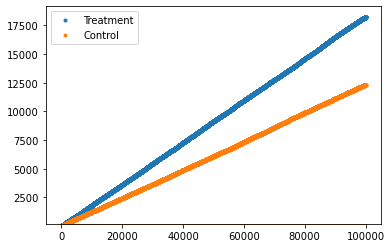

In [50]:
plt.figure()
plt.plot(summa1,'.')
plt.plot(summa2,'.')
plt.ylim(200)
plt.legend(['Treatment', 'Control'])

Из графика видно, что конверсия в тритмент группе выше, следовательно есть эффект он нашего воздействия, и больше людей подключит услугу.

In [51]:
df_student_3['treatment'].replace(['control'], ['0'], regex=True, inplace = True)
df_student_3['treatment'].replace(['treatment'], ['1'], regex=True, inplace = True)

In [52]:
df_treat_3 = df_student_3[df_student_3.treatment == '1']
df_control_3 = df_student_3[df_student_3.treatment == '0']

In [124]:
logreg = LogisticRegression()
cross_val_score(logreg, df_student_3.drop(columns = ['conversion', 'treatment']), df_student_3.treatment).mean()

0.4996250000000001

Логистическая регрессия выдает результат близкий к 0.5, следовательно с большой вероятностью данные распределены рандомной.
Следовательно мы можем сделать предположения об условной независимости (Conditional Independence Assumption — CIA): разделение на целевую и контрольную группу происходит случайно, а не в зависимости от значения какого-то признака.

### 1. Оценка ATE

Регрессией

In [107]:
linreg = LinearRegression()
linreg.fit(df_student_3.drop(columns = ['conversion']), df_student_3.conversion)
ATE = linreg.coef_[0]

In [108]:
print('ATE = ', ATE)

ATE =  0.060573854556001984


Разницей средних

In [138]:
df_treat_3.conversion.mean() - df_control_3.conversion.mean()

0.05907

### 2. Оценка CATE для каждого наблюдения

In [112]:
import econml
from econml.metalearners import TLearner, SLearner, XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

Произведем оценку CATE при помощи трех методов: S-learner, T-learner, X-learner.

In [113]:
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6)
S_learner = SLearner(overall_model)
S_learner.fit(df_student_3.conversion, df_student_3.treatment, X=df_student_3.drop(columns=['treatment', 'conversion']))
S_te = S_learner.effect(df_student_3.drop(columns=['treatment', 'conversion']))

In [244]:
df_student_3_S = df_student_3.copy()
df_student_3_S['S_learn'] = S_te
df_student_3_S.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,S_learn
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0.011566
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,0.001350
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0.011942
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,1.006130
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0.006117


In [115]:
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
T_learner = TLearner(models)

In [116]:
T_learner.fit(df_student_3.conversion, df_student_3.treatment, X=df_student_3.drop(columns=['treatment', 'conversion']))

In [117]:
T_te = T_learner.effect(df_student_3.drop(columns=['treatment', 'conversion']))

In [241]:
df_student_3_T = df_student_3.copy()
df_student_3_T['T_learn'] = T_te
df_student_3_T.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,T_learn
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0.007077
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,-0.006494
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0.010761
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,0.979386
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0.005715


In [120]:
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_learner = XLearner(models=models, propensity_model=propensity_model)
X_learner.fit(df_student_3.conversion, df_student_3.treatment, X=df_student_3.drop(columns=['treatment', 'conversion']))
X_te = X_learner.effect(df_student_3.drop(columns=['treatment', 'conversion']))

In [478]:
df_student_3_X = df_student_3.copy()
df_student_3_X['X_learn'] = X_te
df_student_3_X.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,X_learn
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0.021379
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,-0.021374
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0.011352
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,0.969720
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0.004957


График распределения CATE в зависимости от способа

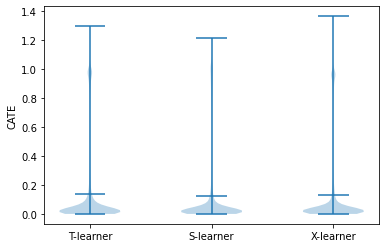

In [122]:
plt.violinplot([np.abs(T_te), 
                np.abs(S_te),
                np.abs(X_te),
               ], showmeans=True)
plt.ylabel("CATE")
plt.xticks([1, 2, 3], ['T-learner', 'S-learner', 'X-learner'])
plt.show()

По графикам видно, что все три метода дают приблизительно одинаковые результаты, и 90 процентов данных лежат ниже 0.2 процентов

### 3. Рекомендации к воздействию на каждый объект

Построим графики зависимости конверсии от CATE

In [472]:
def graph(df, Name):
    res = []
    for i in np.arange(0, 1, 0.01):
        df[df[Name] > i]
        perem = df[df[Name] > i]
        res.append(perem.conversion.value_counts()[1]/perem.conversion.shape[0])
    maxim = max(res)
    index_max = np.argmax(res)
    plt.plot(np.arange(0, 1, 0.01), res) 
    plt.xlabel('CATE')
    plt.title(Name)
    plt.show()
    print('Max_Conversion = ', maxim, '\nCATE = ',index_max/100)

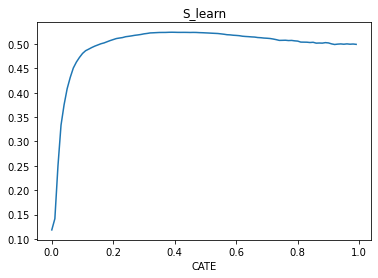

Max_Conversion =  0.5243895593600898 
CATE =  0.39


In [473]:
graph(df_student_3_S, 'S_learn')

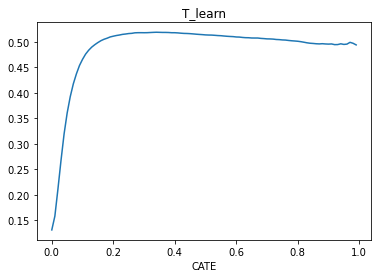

Max_Conversion =  0.5189012782159369 
CATE =  0.34


In [474]:
graph(df_student_3_T, 'T_learn')

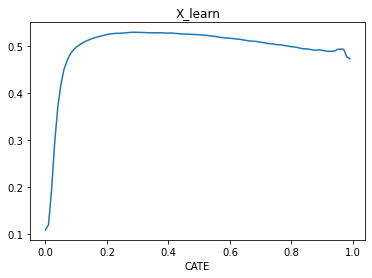

Max_Conversion =  0.5298041517690378 
CATE =  0.29


In [475]:
graph(df_student_3_X,'X_learn')

Из графиков видно что, для лучшей конверсии лучше всего использовать X-learn примерно при CATE больше 0.29

Следовательно посоветуем услугу только тем, чей CATE больше 0.29 процентов

In [479]:
df_student_3_X['Recomendation'] = 0
df_student_3_X.loc[df_student_3_X["X_learn"] > 0.29, "Recomendation"] = 1
df_student_3_X

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,X_learn,Recomendation
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0.021379,0
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,-0.021374,0
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0.011352,0
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,0.969720,1
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0.004957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,-1.309691,2.925832,-0.584101,-1.232931,2.601140,-4.943288,0.416758,-0.083626,-1.232931,...,0.636279,1.073711,-0.406603,0.027760,-0.478887,1.265746,0.059865,0,0.016656,0
199996,0,-1.131361,1.562317,1.265630,-1.361879,1.169695,-3.247293,1.253718,-1.968727,-1.361879,...,0.892121,0.893261,0.182528,0.338611,1.006028,-1.943045,-0.145377,0,-0.036046,0
199997,0,0.442433,2.202153,-0.380019,-0.474935,0.766306,-1.722354,0.751083,0.595800,-0.474935,...,0.718669,1.031289,0.398560,0.591750,1.620529,-1.081292,0.995816,0,-0.011763,0
199998,1,-0.084879,0.423688,0.389931,-1.996510,-0.123098,-1.103408,2.207197,0.402468,-1.996510,...,-0.256026,2.231563,0.848577,0.739235,1.656343,0.436962,0.622010,0,-0.020454,0


### 4. Ожидаемая конверсия при оптимальном воздействии

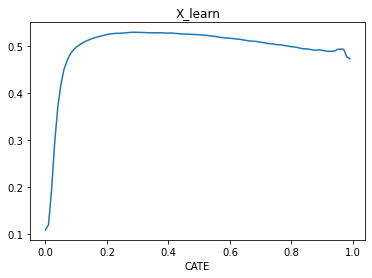

Max_Conversion =  0.5298041517690378 
CATE =  0.29


In [480]:
# Конверсия
graph(df_student_3_X,'X_learn')

Из графика видно, что конверсия такого воздействия 0.529%

### 5. Выводы

В итоге:   

    1) Тритмент и контрол группы распределены равномерно. Эксперимент рандомезированный, так как 
    классификатор не может выделить тритмент и контрол группу с достаточной точностью.  Следовательно мы можем сделать 
    предположения об условной независимости (Conditional Independence Assumption — CIA): разделение на целевую и контрольную 
    группу происходит случайно, а не в зависимости от значения какого-то признака.
    
    2) Провели оценку АТЕ двумя методами: регрессией и разницей средних, оба метода показали результат 0.06.
    
    3) Оценили CATE для каждого наблюдения:
        а) S_learner - 0.518 conversion
        б) T_learner - 0.524 conversion
        в) X_learner - 0.529 conversion
    В итоге рекомендовали воздействие на каждый объект, всего получилось примерно 18700 воздействий. Использовали при этом 
    X_learner модель.
